In [1]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [2]:
data = pd.read_csv("Bundesliga_22_23.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [3]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

In [4]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.matchId==next_actions.matchId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['matchId' ] = nex.matchId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team_name','playerName','h_a']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['playerName' ]= nex.playerName
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['matchId','period','action_id']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [5]:
data = add_carries(data)

In [109]:
data_andre = data[data['playerId'] == 369570]

In [110]:
data_andre

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
9215,NaN,NaN,NaN,NaN,NaN,134.0,h,39.12,57.20,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Borussia M.Gladbach,71.5,9215
9223,NaN,NaN,NaN,NaN,NaN,134.0,h,43.56,73.60,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Borussia M.Gladbach,84.5,9223
9226,NaN,NaN,NaN,NaN,NaN,134.0,h,71.40,65.60,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Borussia M.Gladbach,100.0,9226
9264,NaN,NaN,NaN,NaN,NaN,134.0,h,69.12,22.40,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Borussia M.Gladbach,207.5,9264
9270,NaN,NaN,NaN,NaN,NaN,134.0,h,43.44,31.36,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Borussia M.Gladbach,217.5,9270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706586,1353.0,2.552686e+09,722.0,72.0,11.0,134.0,a,38.64,49.20,74.0,...,False,False,True,False,False,True,NaN,Borussia M.Gladbach,4331.0,706586
706591,1358.0,2.552686e+09,727.0,72.0,27.0,134.0,a,80.04,59.04,74.0,...,False,False,False,False,True,True,NaN,Borussia M.Gladbach,4347.0,706591
706596,1363.0,2.552687e+09,732.0,72.0,33.0,134.0,a,102.48,40.48,74.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,4353.0,706596
706599,1366.0,2.552687e+09,733.0,72.0,36.0,134.0,a,111.72,56.00,74.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,4356.0,706599


In [111]:
data_dribbles = data_andre[data_andre['type'] == 'TakeOn']

In [112]:
data_tackles = data_andre[data_andre['type'] == 'Tackle']

In [113]:
tackles_won = data_tackles[data_tackles['tackleWon'] == True]
tackles_lost = data_tackles[data_tackles['tackleLost'] == True]

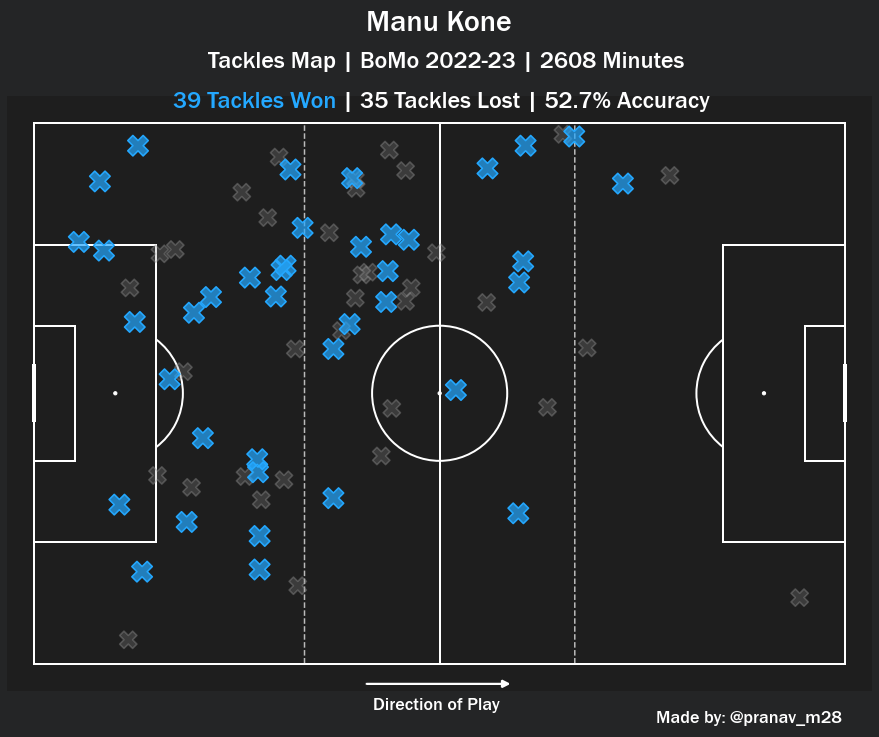

In [178]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)


#Plotting Tackles Won

pitch.scatter(tackles_won.x, tackles_won.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(tackles_won.x, tackles_won.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting Tackles Lost

pitch.scatter(tackles_lost.x, tackles_lost.y, s=300,
              marker='X', edgecolors='#949494', c='none', zorder=3, ax=ax , alpha=0.4 , ls='-' , lw=1.6)

pitch.scatter(tackles_lost.x, tackles_lost.y, s=300,
              marker='X', edgecolors='none', c='#949494', zorder=3, ax=ax , alpha=0.25)




plt.gca().invert_yaxis()

fig_text(
    0.512, 0.945, "<Manu Kone>", font='Franklin Gothic Medium' , size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Tackles Map | BoMo 2022-23 | 2608 Minutes",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)




fig_text(
    0.514, 0.851,
    "<39 Tackles Won> | 35 Tackles Lost | 52.7% Accuracy",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color" : "#24a8ff"}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)   


#plt.savefig("Kone 2022-23 Tackling.png" , dpi=300, bbox_inches='tight')

In [115]:
tackles_won['x'].count()

39

In [116]:
tackles_lost['x'].count()

35

In [176]:
39/74

0.527027027027027

In [118]:
data_dribbles

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
11307,1226.0,2.442600e+09,759.0,74.0,46.0,134.0,h,64.80,18.08,77.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,4486.0,11307
36820,687.0,2.445525e+09,464.0,43.0,24.0,134.0,a,67.92,19.44,43.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,2604.0,36820
37666,1202.0,2.445922e+09,948.0,76.0,16.0,134.0,a,84.84,24.00,79.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,4576.0,37666
61111,286.0,2.451764e+09,340.0,14.0,46.0,134.0,a,48.24,55.36,14.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,886.0,61111
61209,384.0,2.451731e+09,181.0,22.0,32.0,134.0,a,85.92,21.76,22.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,1352.0,61209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672083,245.0,2.548501e+09,875.0,12.0,0.0,134.0,a,117.84,61.52,12.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,720.0,672083
672093,255.0,2.548038e+09,138.0,12.0,50.0,134.0,a,66.12,53.60,12.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,770.0,672093
704986,257.0,2.552643e+09,150.0,12.0,23.0,134.0,a,65.28,53.92,12.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,743.0,704986
705459,730.0,2.552657e+09,442.0,38.0,32.0,134.0,a,62.88,60.72,38.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,2312.0,705459


In [119]:
dribbles_won = data_dribbles[data_dribbles['dribbleWon'] == True]
dribbles_lost = data_dribbles[data_dribbles['dribbleLost'] == True]

In [120]:
dribbles_won['x'].count()

57

In [121]:
dribbles_lost['x'].count()

61

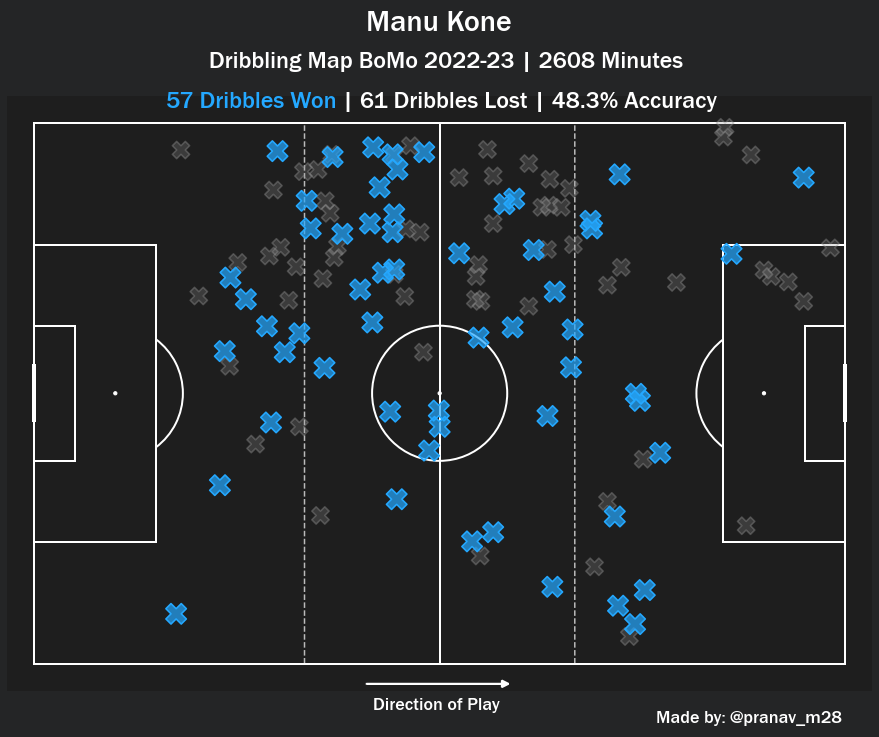

In [175]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)


#Plotting TakeOns Won

pitch.scatter(dribbles_won.x, dribbles_won.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(dribbles_won.x, dribbles_won.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)

#Plotting TakeOns Lost

pitch.scatter(dribbles_lost.x, dribbles_lost.y, s=300,
              marker='X', edgecolors='#949494', c='none', zorder=3, ax=ax , alpha=0.4 , ls='-' , lw=1.6)

pitch.scatter(dribbles_lost.x, dribbles_lost.y, s=300,
              marker='X', edgecolors='none', c='#949494', zorder=3, ax=ax , alpha=0.25)




plt.gca().invert_yaxis()

fig_text(
    0.512, 0.945, "<Manu Kone>", font='Franklin Gothic Medium' , size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Dribbling Map BoMo 2022-23 | 2608 Minutes",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)




fig_text(
    0.514, 0.851,
    "<57 Dribbles Won> | 61 Dribbles Lost | 48.3% Accuracy",
    font='Franklin Gothic Medium' , size=24,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color" : "#24a8ff"}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)   


#plt.savefig("Kone 22-23 Dribbling.png" , dpi=300, bbox_inches='tight')

In [123]:
dribbles_won['x'].count()

57

In [124]:
dribbles_lost['x'].count()

61

In [173]:
dribbles_won['x'].count()/(dribbles_won['x'].count()+dribbles_lost['x'].count())

0.4830508474576271

In [126]:
recov = data_andre[data_andre['ballRecovery'] == True]

In [127]:
recov

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
9609,10.0,2.442476e+09,4.0,0.0,17.0,134.0,h,73.68,68.24,0.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,17.0,9609
10144,545.0,2.442506e+09,331.0,35.0,52.0,134.0,h,85.44,18.72,35.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,2152.0,10144
10225,626.0,2.442515e+09,376.0,39.0,54.0,134.0,h,78.24,10.32,39.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,2394.0,10225
11066,985.0,2.442587e+09,601.0,58.0,31.0,134.0,h,37.56,47.28,61.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,3511.0,11066
11265,1184.0,2.442595e+09,745.0,70.0,26.0,134.0,h,90.72,13.84,73.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,4226.0,11265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673636,1302.0,2.548104e+09,649.0,71.0,37.0,134.0,a,24.12,8.08,72.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,4297.0,673636
704927,198.0,2.552642e+09,110.0,9.0,52.0,134.0,a,16.20,64.16,9.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,592.0,704927
704943,214.0,2.552642e+09,113.0,10.0,32.0,134.0,a,53.16,51.20,10.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,632.0,704943
706425,1192.0,2.552681e+09,654.0,61.0,28.0,134.0,a,47.40,45.60,63.0,...,False,False,False,False,False,False,NaN,Borussia M.Gladbach,3688.0,706425


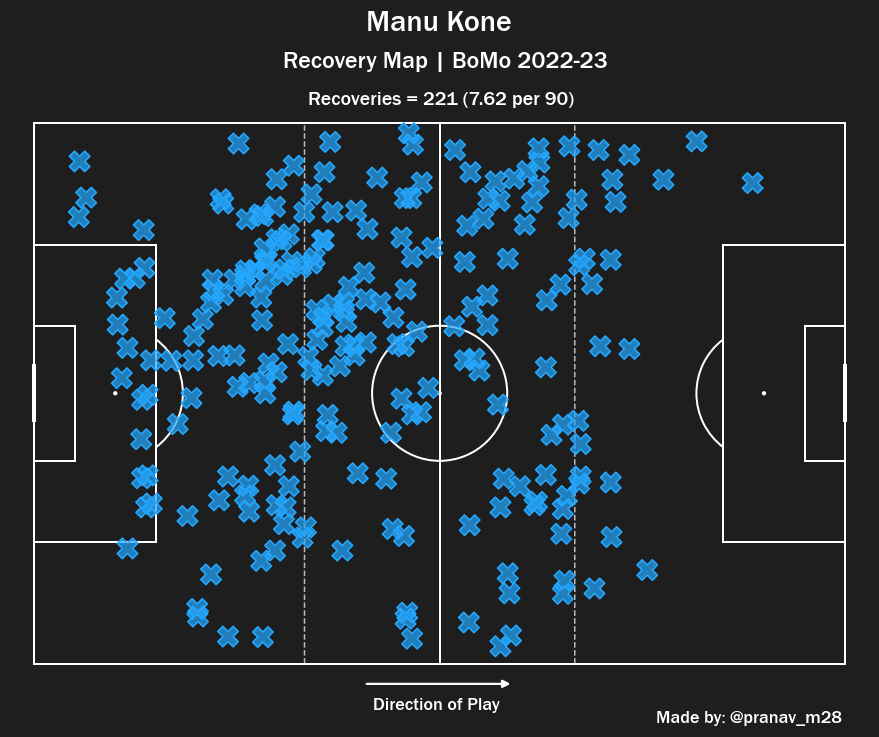

In [181]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#1e1e1e')
ax.patch.set_facecolor('#1e1e1e')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True , line_zorder=2)

pitch.draw(ax=ax)

#bin_statistic = pitch.bin_statistic(recov.x, recov.y, statistic='count', bins=(25, 25))
#bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
#pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#000000' , alpha=0.88)

pitch.scatter(recov.x, recov.y, s=420,
              marker='X', edgecolors='#24a8ff', c='none', zorder=4, ax=ax , alpha=1 , ls='-' , lw=1.6)

pitch.scatter(recov.x, recov.y, s=420,
              marker='X', edgecolors='none', c='#24a8ff', zorder=4, ax=ax , alpha=0.70)




plt.gca().invert_yaxis()


fig_text(
    0.512, 0.945, "<Manu Kone>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.898,
    "Recovery Map | BoMo 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.514, 0.851,
    "Recoveries = 221 (7.62 per 90)",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.514, 0.851,
    "<>",
    size=13,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)  

#plt.savefig('Kone Recoveries.png' , dpi=300 , bbox_inches='tight')

In [129]:
recov['x'].count()

221

In [179]:
221/29

7.620689655172414

In [131]:
73/105

0.6952380952380952

In [132]:
##Passing Vizzes
data_passes = data_andre[data_andre['type'] == 'Pass']

In [133]:
data_passes

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,...,subOn,subOff,defensiveThird,midThird,finalThird,pos,isOwnGoal,team_name,time_seconds,action_id
9610,11.0,2.442477e+09,5.0,0.0,18.0,134.0,h,73.44,67.84,0.0,...,False,False,False,False,True,True,NaN,Borussia M.Gladbach,18.0,9610
9634,35.0,2.442477e+09,16.0,1.0,13.0,134.0,h,39.12,57.20,1.0,...,False,False,True,False,False,True,NaN,Borussia M.Gladbach,73.0,9634
9639,40.0,2.442477e+09,21.0,1.0,26.0,134.0,h,41.04,73.60,1.0,...,False,False,True,False,False,True,NaN,Borussia M.Gladbach,86.0,9639
9644,45.0,2.442478e+09,25.0,1.0,41.0,134.0,h,71.40,65.20,1.0,...,False,False,False,True,False,True,NaN,Borussia M.Gladbach,101.0,9644
9682,83.0,2.442479e+09,59.0,3.0,28.0,134.0,h,69.00,21.92,3.0,...,False,False,False,True,False,True,NaN,Borussia M.Gladbach,208.0,9682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706453,1220.0,2.552682e+09,675.0,63.0,2.0,134.0,a,78.60,65.84,65.0,...,False,False,False,False,True,True,NaN,Borussia M.Gladbach,3782.0,706453
706524,1291.0,2.552684e+09,695.0,67.0,9.0,134.0,a,79.80,63.76,69.0,...,False,False,False,False,True,True,NaN,Borussia M.Gladbach,4029.0,706524
706578,1345.0,2.552686e+09,714.0,71.0,44.0,134.0,a,31.32,63.84,73.0,...,False,False,True,False,False,True,NaN,Borussia M.Gladbach,4304.0,706578
706586,1353.0,2.552686e+09,722.0,72.0,11.0,134.0,a,38.64,49.20,74.0,...,False,False,True,False,False,True,NaN,Borussia M.Gladbach,4331.0,706586


In [134]:
data_succ = data_passes[data_passes['outcomeType'] == 'Successful']
data_unsucc = data_passes[data_passes['outcomeType'] == 'Unsuccessful']

In [135]:
data_succ_prog = data_succ.reset_index()
data_unsucc_prog = data_unsucc.reset_index()
data_succ_prog['beginning'] = np.sqrt(np.square(120-data_succ_prog['x']) + np.square(40 - data_succ_prog['y']))
data_succ_prog['end'] = np.sqrt(np.square(120 - data_succ_prog['endX']) + np.square(40 - data_succ_prog['endY']))

data_succ_prog['progressive'] = [(data_succ_prog['end'][x]) / (data_succ_prog['beginning'][x]) < .75 for x in range(len(data_succ_prog.beginning))]
data_succ_prog = data_succ_prog[data_succ_prog['progressive'] == True]

In [136]:
data_carries = data_andre[data_andre['type'] == 'Carry']

data_carries_succ = data_carries[data_carries['outcomeType'] == 'Successful']
data_carries_unsucc = data_carries[data_carries['outcomeType'] == 'Unsuccessful']

data_carries_succ_prog = data_carries_succ.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()

data_carries_succ_prog['beginning'] = np.sqrt(np.square(120-data_carries_succ_prog['x']) + np.square(40 - data_carries_succ_prog['y']))
data_carries_succ_prog['end'] = np.sqrt(np.square(120 - data_carries_succ_prog['endX']) + np.square(40 - data_carries_succ_prog['endY']))

data_carries_succ_prog['progressive'] = [(data_carries_succ_prog['end'][x]) / (data_carries_succ_prog['beginning'][x]) < .75 for x in range(len(data_carries_succ_prog.beginning))]
data_carries_succ_prog = data_carries_succ_prog[data_carries_succ_prog['progressive'] == True]

In [137]:
data_carries_succ_prog['x'].count()

33

In [138]:
data_succ_prog = data_succ_prog[data_succ_prog['passCorner'] == False]

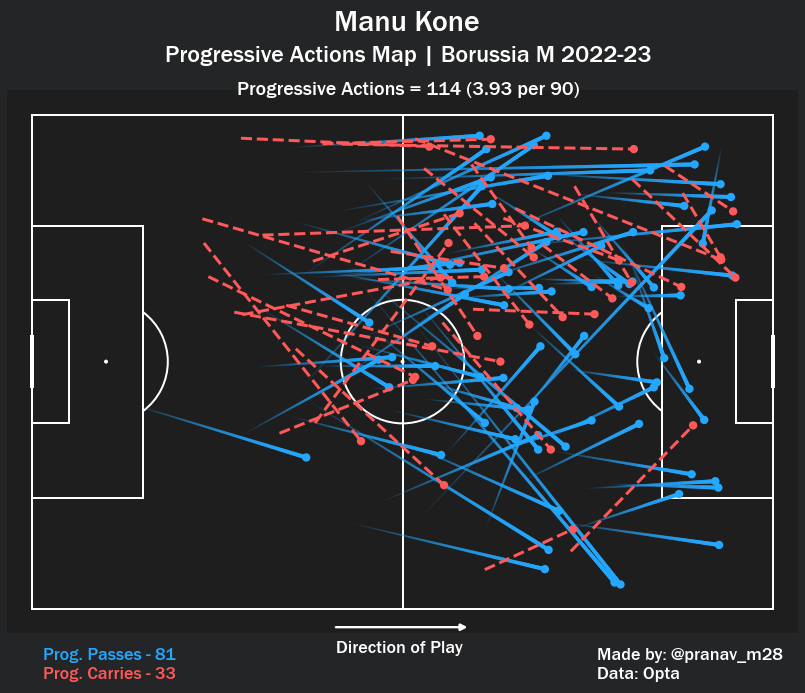

In [164]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Progressive Passes

lc1 = pitch.lines(data_succ_prog.x, data_succ_prog.y,
                  data_succ_prog.endX, data_succ_prog.endY,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax)

pitch.scatter(data_succ_prog.endX, data_succ_prog.endY, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=2,
              label='goal', ax=ax , alpha=1)


#Plotting Progressive Carries

lc1 = pitch.lines(data_carries_succ_prog.x, data_carries_succ_prog.y,
                  data_carries_succ_prog.endX, data_carries_succ_prog.endY,ls='dashed',
                  lw=3, transparent=False, comet=False, label='completed passes',
                  color='#FF5959', ax=ax)

pitch.scatter(data_carries_succ_prog.endX, data_carries_succ_prog.endY, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=2,
              label='goal', ax=ax , alpha=1)

plt.gca().invert_yaxis()


fig_text(
    0.516, 0.99, "<Manu Kone>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Progressive Actions Map | Borussia M 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.518, 0.892,
    "Progressive Actions = 114 (3.93 per 90)",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.250, 0.105, "<Prog. Passes - 81>\n<Prog. Carries - 33>", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#24a8ff'} , {"color": '#FF5959'}]
)

plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Kone Progressive Actions 22-23.png' , dpi=300 , bbox_inches='tight')


In [140]:
data_succ_prog['x'].count()

81

In [162]:
(81+33)/29

3.9310344827586206

In [142]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

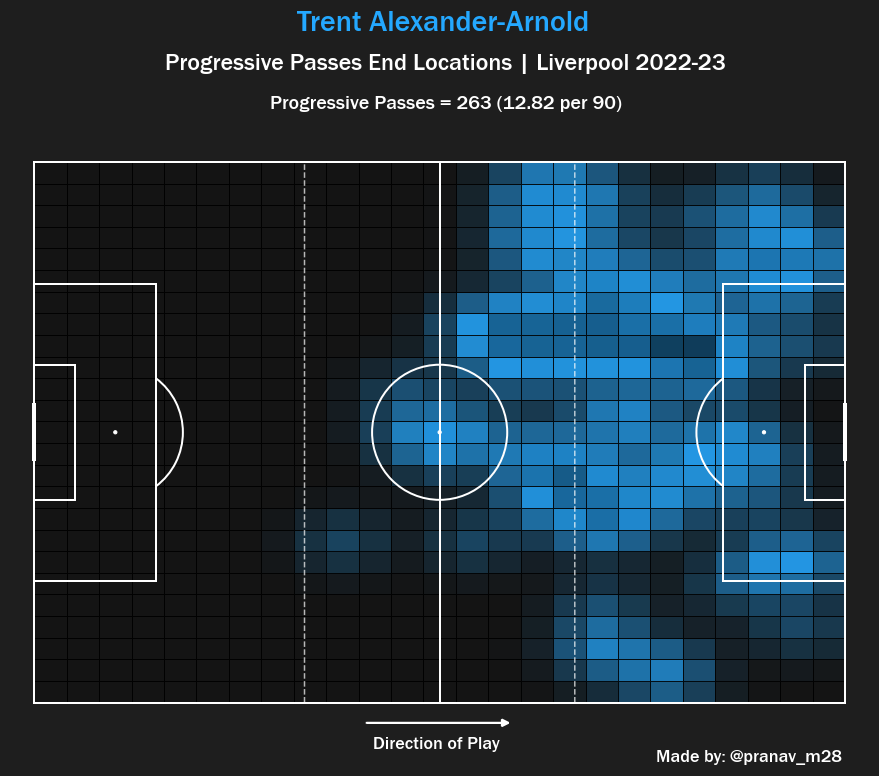

In [143]:
fig ,ax = plt.subplots(figsize=(15.5,12))
fig.set_facecolor('#1e1e1e')
ax.patch.set_facecolor('#1e1e1e')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 12),
              constrained_layout=False, tight_layout=True , line_zorder=2)

pitch.draw(ax=ax)

bin_statistic = pitch.bin_statistic(data_succ_prog.endX, data_succ_prog.endY, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors='#000000' , alpha=0.88)

plt.gca().invert_yaxis()


fig_text(
    0.516, 0.99, "<Trent Alexander-Arnold>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#24a8ff'}]
)

fig_text(
    0.518, 0.941,
    "Progressive Passes End Locations | Liverpool 2022-23",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.518, 0.892,
    "Progressive Passes = 263 (12.82 per 90)",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


fig_text(
    0.514, 0.851,
    "<>",
    size=13,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)




fig_text(
    0.790, 0.135, "Made by: @pranav_m28", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)



fig_text(
    0.510, 0.150, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)



plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'
    

pitch.lines(40 , 0 , 40 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)

pitch.lines(80 , 0 , 80 , 80 , ls='--' , lw=1.5 , color='#FFFFFF' , ax=ax , zorder=1 , alpha=0.7)  

#plt.savefig('Andre Progressive Passes End Locations.png' , dpi=300 , bbox_inches='tight')



In [144]:
recov_mid = recov[(recov['x'] <= 80) & (recov['x'] >= 40)]

In [145]:
recov_mid['x'].count()

109

In [146]:
recov_def = recov[recov['x'] <= 40]

In [147]:
recov_def['x'].count()

90

In [148]:
data_andre['x_n'] = data_andre['x'].shift(-1)
data_andre['y_n'] = data_andre['y'].shift(-1)
data_andre['endX_n'] = data_andre['endX'].shift(-1)
data_andre['endY_n'] = data_andre['endY'].shift(-1)
data_andre['type_n'] = data_andre['type'].shift(-1)
data_andre['outcomeType_n'] = data_andre['outcomeType'].shift(-1)
recov_2 = data_andre[data_andre['type'] == 'BallRecovery']
succ_pass_afrecov = recov_2[recov_2['outcomeType_n'] == 'Successful']
succ_pass_afrecov_prog = succ_pass_afrecov.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()
succ_pass_afrecov_prog['beginning'] = np.sqrt(np.square(120-succ_pass_afrecov_prog['x_n']) + np.square(40 - succ_pass_afrecov_prog['y_n']))
succ_pass_afrecov_prog['end'] = np.sqrt(np.square(120 - succ_pass_afrecov_prog['endX_n']) + np.square(40 - succ_pass_afrecov_prog['endY_n']))

succ_pass_afrecov_prog['progressive'] = [(succ_pass_afrecov_prog['end'][x]) / (succ_pass_afrecov_prog['beginning'][x]) < .75 for x in range(len(succ_pass_afrecov_prog.beginning))]
succ_pass_afrecov_prog = succ_pass_afrecov_prog[succ_pass_afrecov_prog['progressive'] == True]

#Unsucc Passes

unsucc_pass_afrecov = recov_2[recov_2['outcomeType_n'] == 'Unsuccessful']
unsucc_pass_afrecov_prog = unsucc_pass_afrecov.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()
unsucc_pass_afrecov_prog['beginning'] = np.sqrt(np.square(120-unsucc_pass_afrecov_prog['x_n']) + np.square(40 - unsucc_pass_afrecov_prog['y_n']))
unsucc_pass_afrecov_prog['end'] = np.sqrt(np.square(120 - unsucc_pass_afrecov_prog['endX_n']) + np.square(40 - unsucc_pass_afrecov_prog['endY_n']))

unsucc_pass_afrecov_prog['progressive'] = [(unsucc_pass_afrecov_prog['end'][x]) / (unsucc_pass_afrecov_prog['beginning'][x]) < .75 for x in range(len(unsucc_pass_afrecov_prog.beginning))]
unsucc_pass_afrecov_prog = unsucc_pass_afrecov_prog[unsucc_pass_afrecov_prog['progressive'] == True]




C:\Users\91852\AppData\Local\Temp/ipykernel_20684/83920504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_andre['x_n'] = data_andre['x'].shift(-1)
C:\Users\91852\AppData\Local\Temp/ipykernel_20684/83920504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_andre['y_n'] = data_andre['y'].shift(-1)
C:\Users\91852\AppData\Local\Temp/ipykernel_20684/83920504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [149]:
unsucc_pass_afrecov['endX_n'].count()

25

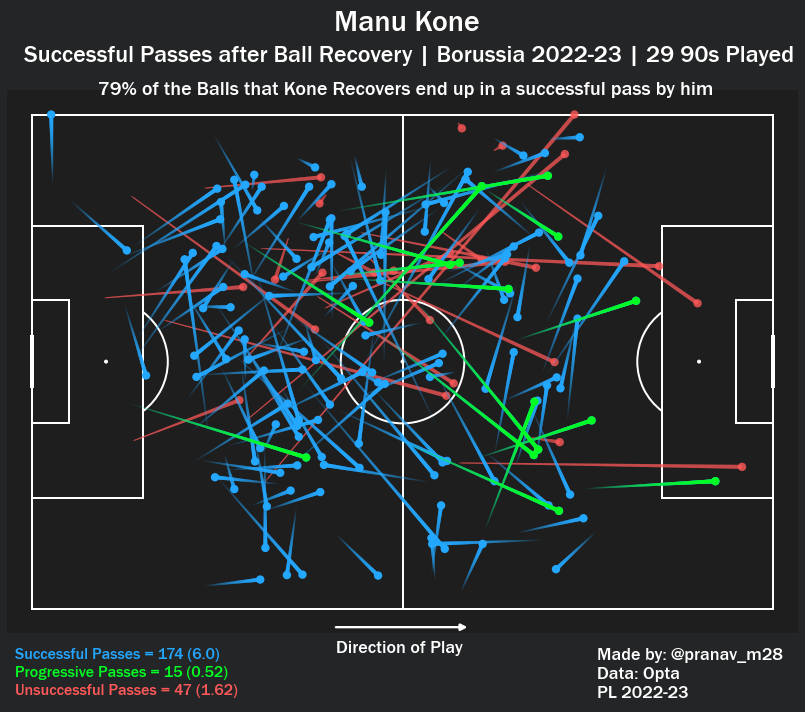

In [172]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
              pitch_color='#1e1e1e', line_color='#FFFFFF', figsize=(15, 10),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

#Plotting Passes post Recovery

lc1 = pitch.lines(succ_pass_afrecov.x_n, succ_pass_afrecov.y_n,
                  succ_pass_afrecov.endX_n, succ_pass_afrecov.endY_n,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax , ZORDER=3)

pitch.scatter(succ_pass_afrecov.endX_n, succ_pass_afrecov.endY_n, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=3,
              label='goal', ax=ax , alpha=1)

#Plotting Prog Passes post Recovery

lc1 = pitch.lines(succ_pass_afrecov_prog.x_n, succ_pass_afrecov_prog.y_n,
                  succ_pass_afrecov_prog.endX_n, succ_pass_afrecov_prog.endY_n,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#03fc24', ax=ax, ZORDER=4)

pitch.scatter(succ_pass_afrecov_prog.endX_n, succ_pass_afrecov_prog.endY_n, s=70,
              marker='o', edgecolors='none', c='#03fc24', zorder=4,
              label='goal', ax=ax , alpha=1)


#Plotting Unsuccessful Passes post Recovery

lc1 = pitch.lines(unsucc_pass_afrecov.x_n, unsucc_pass_afrecov.y_n,
                  unsucc_pass_afrecov.endX_n, unsucc_pass_afrecov.endY_n,
                  lw=4, transparent=True, comet=True, label='completed passes',
                  color='#FF5959', ax=ax , alpha=0.5)

pitch.scatter(unsucc_pass_afrecov.endX_n, unsucc_pass_afrecov.endY_n, s=70,
              marker='o', edgecolors='none', c='#FF5959', zorder=1,
              label='goal', ax=ax , alpha=0.8)



plt.gca().invert_yaxis()


fig_text(
    0.516, 0.99, "<Manu Kone>", font='Franklin Gothic Medium' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Successful Passes after Ball Recovery | Borussia 2022-23 | 29 90s Played",
    font='Franklin Gothic Medium' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.518, 0.892,
    "79% of the Balls that Kone Recovers end up in a successful pass by him ",
    font='Franklin Gothic Medium' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta\nPL 2022-23", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.265, 0.105, "<Successful Passes = 174 (6.0)>\n<Progressive Passes = 15 (0.52)>\n<Unsuccessful Passes = 47 (1.62)>",
    font='Franklin Gothic Medium' ,size=16,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#24a8ff'} , {"color": '#03fc24'}
                                                                           , {"color" : "#FF5959"}]
)

plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.115, "Direction of Play", font='Franklin Gothic Medium' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Kone 22-23 post-Recovery pass map.png' , dpi=300 , bbox_inches='tight')

In [151]:
succ_pass_afrecov_prog['x'].count()

15

In [152]:
succ_pass_afrecov['x'].count()

174

In [153]:
unsucc_pass_afrecov['x'].count()

47

In [154]:
succ_pass_afrecov['x'].count()/(succ_pass_afrecov['x'].count() + unsucc_pass_afrecov['x'].count())

0.7873303167420814

In [165]:
174/29

6.0

In [168]:
47/29

1.6206896551724137

In [157]:
18/32.3

0.5572755417956656

In [158]:
39/32.3

1.2074303405572757

data